In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from jax import config
config.update("jax_debug_nans", True)

In [3]:
import os

from tqdm import trange, tqdm

import numpy as np
from scipy.stats import sem

import pandas as pd

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns

from modules.diagnostics.visualizers import visualize_forecast_horizon_accuracy, visualize_time_series, visualize_time_series_components_performance
from modules.diagnostics.metrics import compute_rmse, compute_symmetric_absolute_percentage_error
from modules.data_handling.data_splitters import split_time_series_df


# Preface

The following notebook rely for a good part on a custom modules which can be found in the modules folder. The structure of the notebook follows roughly these steps

1. Constants definitions
2. Data loading
3. Brief Data Exploration
4. Modelling
    * Baselines
    * Advanced Models

Although point 3 includes some data exploration steps, a substantial part of this is also conducted during the modelling phase by looking at model fit and residuals behaviour

# Constants

Here we will define constants that will be used acrossed the notebook

In [4]:
TRAINING_END_DATE = "2016-01-01"

DATA_FOLDER = "data"
GHI_FILE = "irradiance.csv"
WEATHER_FORECAST_FILES = [
    "nam_lat38.579454_lon121.260320.csv",
    "nam_lat38.599891_lon121.126680.csv",
    "nam_lat38.704328_lon121.152788.csv",
    "nam_lat38.683880_lon121.286556.csv"

]
SATELLITE_FILE = "satellite.csv"

# Data Loading

In this first section we will focus on loading the data dn conducting very preliminary data manipulation operations. Further data processing will be conducted in a second moment.

After several considerations we opted to utilize only satellite data as covariates for modelling, the weather forecast data appeared to be too erratic for being reliable. The sky image would have required an excessive ammout of pre-processing and analysis in order to execute

## GHI Data

From Wikipedia about GHI:

*Global horizontal irradiance (GHI) is the total irradiance from the Sun on a horizontal surface on Earth. It is the sum of direct irradiance (after accounting for the solar zenith angle of the Sun z) and diffuse horizontal irradiance*

$$GHI = DHI + DNI × cos ⁡ ( z ) {\displaystyle {\text{GHI}}={\text{DHI}}+{\text{DNI}}\times \cos(z)}$$

In [5]:
ghi_df = pd.read_csv(os.path.join(DATA_FOLDER, GHI_FILE), parse_dates=["timeStamp"])
# We ensure ghi data are continuous
idx = pd.date_range(ghi_df["timeStamp"].min(), ghi_df["timeStamp"].max(), freq="1min")
ghi_df = ghi_df.set_index("timeStamp") 
ghi_df = (
    ghi_df
    .reindex(idx, fill_value=np.nan)
    .interpolate("linear")
)

ghi_df = (
    ghi_df
    .reset_index()
    .rename({"index": "time"}, axis=1)
)

## Satellite Images (black and white)

These specifically are GOES-15 images which according to wikipedia are black and white images produced by geosptial satellite. In our case the 10x10 format highlight the low resolution of the image.

In [6]:
satellite_df = pd.read_csv(os.path.join(DATA_FOLDER, SATELLITE_FILE), header=None, parse_dates=[0])
idx = pd.date_range(satellite_df[0].min(), satellite_df[0].max(), freq="15min")
satellite_df = satellite_df.set_index(0) 
satellite_df = (
    satellite_df
    .reindex(idx, fill_value=np.nan)
    .interpolate("nearest")
)

satellite_df = (
    satellite_df
    .reset_index()
    .rename({"index": "time"}, axis=1)
)

# Data Exploration

## GHI Data

In [7]:
ghi_df.describe()

,time,ghi,dni,dhi
count,1575360,1.575360e+06,1.575360e+06,1.575360e+06
mean,2015-07-03 07:59:30.000004096,2.054944e+02,2.560642e+02,5.345318e+01
min,2014-01-02 08:00:00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2014-10-02 19:59:45,0.000000e+00,0.000000e+00,0.000000e+00
50%,2015-07-03 07:59:30,1.280000e+00,0.000000e+00,2.509500e+00
75%,2016-04-01 19:59:15,3.788000e+02,6.538000e+02,7.873000e+01
max,2016-12-31 07:59:00,1.466000e+03,1.004000e+03,7.481000e+02
std,NaN,2.942295e+02,3.618388e+02,8.394639e+01


In [8]:
ghi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1575360 entries, 0 to 1575359
Data columns (total 4 columns):
 #   Column  Non-Null Count    Dtype         
---  ------  --------------    -----         
 0   time    1575360 non-null  datetime64[ns]
 1   ghi     1575360 non-null  float64       
 2   dni     1575360 non-null  float64       
 3   dhi     1575360 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 48.1 MB


In [9]:
# Very relevant
ghi_df["month"] = ghi_df["time"].dt.month
ghi_df["day_year"] = ghi_df["time"].dt.day_of_year
ghi_df["hour"] = ghi_df["time"].dt.hour

# Spurious, these should come out irrelevant if there is no bias in the measurement
ghi_df["year"] = ghi_df["time"].dt.year
ghi_df["day_week"] = ghi_df["time"].dt.day_of_week
ghi_df["minute"] = ghi_df["time"].dt.minute

In [10]:
# We execpt at least 525600 datapoints if data are recorded continuously for 3 years
(
    ghi_df
    .groupby("year")
    .size()
)

year
2014    523680
2015    525600
2016    526080
dtype: int64

/home/penthotal/mambaforge-pypy3/envs/ghi_forecast_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/penthotal/mambaforge-pypy3/envs/ghi_forecast_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/penthotal/mambaforge-pypy3/envs/ghi_forecast_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/penthotal/mambaforge-pypy3/envs/ghi_forecast_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498:

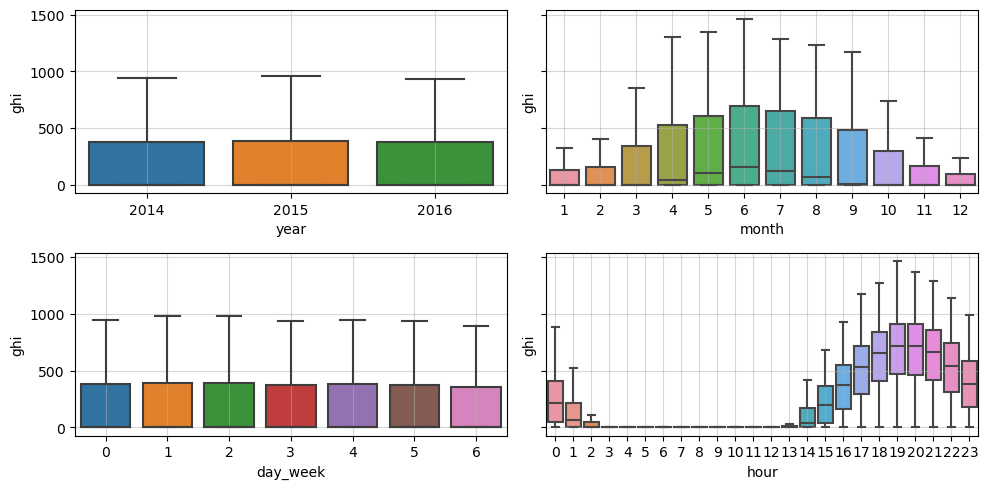

In [11]:
groupers = [
    "year",
    "month",
    "day_week",
    "hour"
]
fig, axs = plt.subplots(2, 2, figsize=(10, 5), sharey=True)

for ax, grouper in zip(axs.flatten(), groupers):

    sns.boxplot(
        data=ghi_df,
        x=grouper,
        y="ghi",
        showfliers=False,
        ax=ax
    )
    ax.grid(alpha=0.5)

plt.tight_layout()
plt.show()

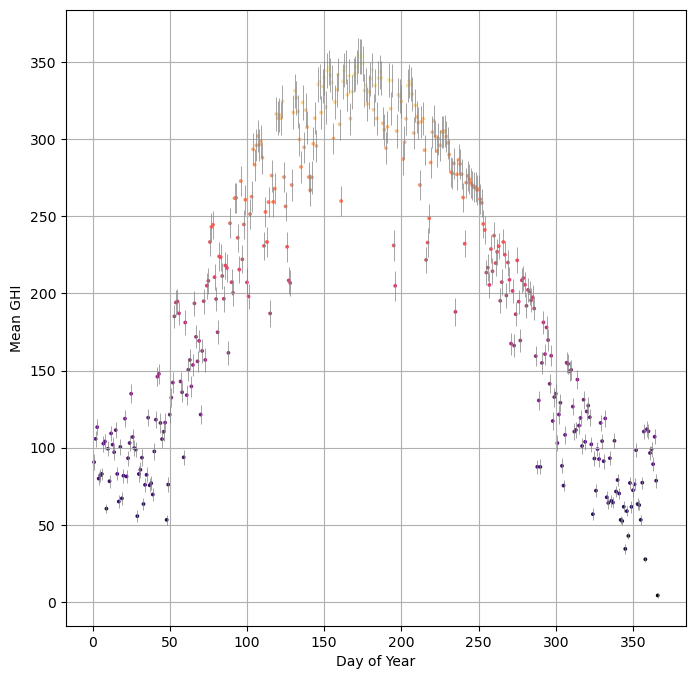

In [12]:
dayly_stats = (
    ghi_df
    .groupby("day_year")
    .agg(
        mean=("ghi", "mean"),
        std_err_mean=("ghi", lambda x: sem(x))
    )
    .reset_index()
    
)

plt.figure(figsize=(8, 8))
plt.scatter(
    x=dayly_stats["day_year"].values,
    y=dayly_stats["mean"].values,
    s=3,
    c=dayly_stats["mean"].values,
    cmap="magma"
)
plt.errorbar(
    x=dayly_stats["day_year"].values,
    y=dayly_stats["mean"].values,
    yerr=dayly_stats["std_err_mean"].values * 1.96,
    linewidth=0.5,
    ls='none',
    c="grey"

)
plt.ylabel("Mean GHI")
plt.xlabel("Day of Year")
plt.grid()

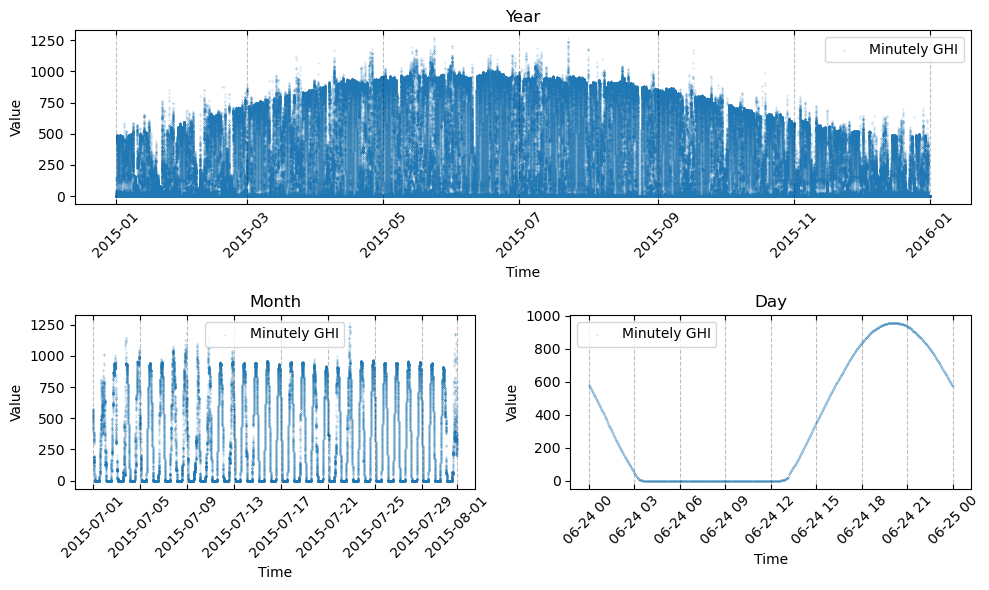

In [13]:
single_year_ghi_df = ghi_df[ghi_df["year"] == 2015]
single_month_ghi_df = ghi_df[(ghi_df["year"] == 2015) & (ghi_df["month"] == 7)]
single_day_ghi_df = ghi_df[(ghi_df["year"] == 2015) & (ghi_df["day_year"] == 175)]

fig = plt.figure(figsize=(10, 6), tight_layout=True)
gs = gridspec.GridSpec(2, 2)

ax_year = fig.add_subplot(gs[0, :])
ax_month = fig.add_subplot(gs[1, 0])
ax_day = fig.add_subplot(gs[1, 1])


axes_dfs = {
   "Year": (ax_year, single_year_ghi_df),
   "Month": (ax_month, single_month_ghi_df),
   "Day": (ax_day, single_day_ghi_df)

}

for title, (ax, df) in axes_dfs.items():

    ax = visualize_time_series(
        ax=ax,
        time_series_name="Minutely GHI",
        time_series=df.set_index("time")["ghi"],
        s=0.05,
        alpha=0.5
    )
    ax.set_title(title)
    ax.legend()

## Satellite Data

In [14]:
satellite_df.head(5)

,time,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,2014-03-13 18:00:00,77.0,76.0,77.0,77.0,84.0,82.0,79.0,76.0,74.0,...,77.0,76.0,75.0,74.0,76.0,76.0,76.0,77.0,77.0,78.0
1,2014-03-13 18:15:00,77.0,76.0,77.0,77.0,84.0,82.0,79.0,76.0,74.0,...,77.0,76.0,75.0,74.0,76.0,76.0,76.0,77.0,77.0,78.0
2,2014-03-13 18:30:00,79.0,77.0,76.0,75.0,89.0,79.0,76.0,74.0,67.0,...,81.0,82.0,80.0,76.0,79.0,78.0,77.0,76.0,77.0,78.0
3,2014-03-13 18:45:00,79.0,77.0,76.0,75.0,89.0,79.0,76.0,74.0,67.0,...,81.0,82.0,80.0,76.0,79.0,78.0,77.0,76.0,77.0,78.0
4,2014-03-13 19:00:00,81.0,80.0,79.0,78.0,86.0,81.0,83.0,80.0,68.0,...,78.0,79.0,78.0,76.0,79.0,79.0,79.0,79.0,80.0,81.0


In [15]:
satellite_df.describe()

,time,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
count,98327,98327.000000,98327.000000,98327.000000,98327.000000,98327.000000,98327.000000,98327.000000,98327.000000,98327.000000,...,98327.000000,98327.000000,98327.000000,98327.000000,98327.000000,98327.000000,98327.000000,98327.000000,98327.000000,98327.000000
mean,2015-08-07 20:45:00.000000512,104.673986,104.354572,104.089691,103.965279,104.878446,104.323492,103.427512,103.123059,102.464542,...,104.924680,105.412308,105.496273,105.406287,106.677362,107.025151,107.638289,108.432760,109.142657,109.312457
min,2014-03-13 18:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2014-11-24 19:22:30,82.000000,81.000000,81.000000,80.000000,82.000000,82.000000,81.000000,80.000000,79.000000,...,82.000000,83.000000,83.000000,83.000000,85.000000,85.000000,86.000000,88.000000,89.000000,89.000000
50%,2015-08-07 20:45:00,95.000000,94.000000,94.000000,93.000000,95.000000,95.000000,95.000000,95.000000,93.000000,...,95.000000,95.000000,96.000000,96.000000,97.000000,97.000000,98.000000,99.000000,100.000000,101.000000
75%,2016-04-19 22:07:30,117.000000,117.000000,117.000000,116.000000,116.000000,116.000000,115.000000,115.000000,115.000000,...,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,118.000000,118.000000,119.000000,119.000000
max,2016-12-31 23:30:00,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000
std,NaN,31.515204,31.803811,31.878095,32.076861,31.736400,32.138111,32.745757,32.914638,33.090754,...,31.432413,31.217330,31.298630,31.428878,30.567715,30.247307,29.893872,29.529785,29.328337,29.243425


In [16]:
satellite_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98327 entries, 0 to 98326
Columns: 101 entries, time to 100
dtypes: datetime64[ns](1), float64(100)
memory usage: 75.8 MB


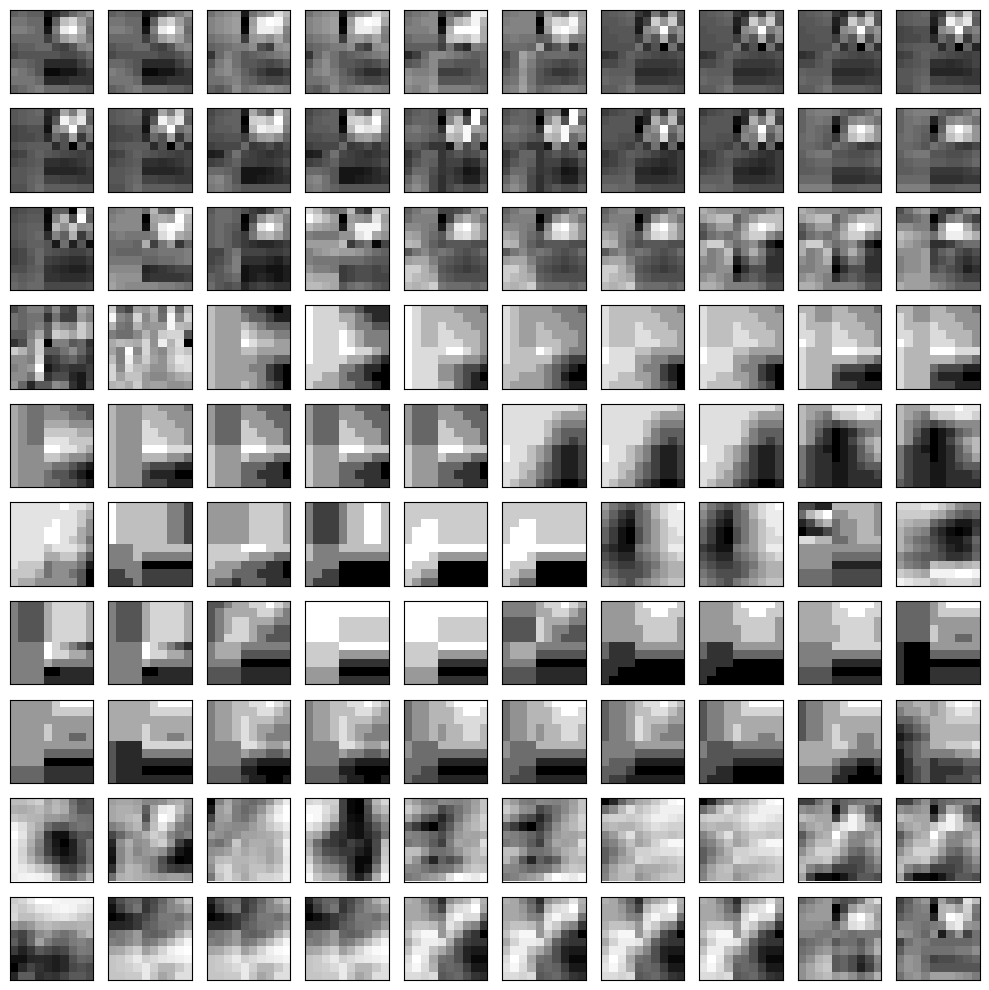

In [17]:
fig, axs = plt.subplots(10, 10, figsize=(10, 10), sharex=True, sharey=True)

for row, ax in enumerate(axs.flatten()):

    satellite_img = satellite_df.loc[row, :][np.arange(1, 101)].values.astype("float")
    satellite_img = satellite_img.reshape(10, 10)

    ax.imshow(satellite_img, cmap="binary")

    ax.set_yticks([])
    ax.set_xticks([])

plt.tight_layout()
plt.show()


# Modelling

In this section we will illustrate some modelling approaches for tackling the problem of minutely forecasting with a 30 minutes time horizons. We will start from some very simple baselines and build complexity using the information provided by the fit of the various models.

First of all we need to specify the different type of evaluation framework we could use for fitting and testing the perfromance of our model, each of them has its strengths and weaknesses and rely on different type of assumptions.

### Expanding window scheme
<img src="images/presentation/expanding_forecast.png" alt="drawing" width="700"/>

### Fixed window scheme
<img src="images/presentation/windowed_forecast.png" alt="drawing" width="700"/>

### Full history scheme
<img src="images/presentation/full_forecast.png" alt="drawing" width="700"/>

## Modelling Data Preparation

Here we perfrom a series of data preparations steps necessary for our modelling attempts

In [18]:
# we shift satellite time by 30 minuts so we are always sure to have covariate data in the future (assuming 30 minutes time to get them)
satellite_df["time"] = satellite_df["time"] + pd.Timedelta("30minutes")

# We divide in-sample and out sample data
insample_ghi_df, outsample_ghi_df = split_time_series_df(
    df=ghi_df,
    start_date=TRAINING_END_DATE,
    time_column="time"
)
insample_satellite_df, outsample_satellite_df = split_time_series_df(
    df=satellite_df,
    start_date=TRAINING_END_DATE,
    time_column="time"
)

insample_ghi_df = (
    insample_ghi_df
    .set_index("time")
    [["ghi", "year", "month", "day_year", "hour", "minute"]]
)
outsample_ghi_df = (
    outsample_ghi_df
    .set_index("time")
    [["ghi", "year", "month", "day_year", "hour", "minute"]]
)

# Join the covariates of interest
insample_satellite_df = (
    insample_satellite_df
    .set_index("time")
)
outsample_satellite_df = (
    outsample_satellite_df
    .set_index("time")
)

insample_ghi_df = pd.merge(
    insample_ghi_df,
    insample_satellite_df,
    how="left",
    on="time"
).interpolate("linear", limit_direction="both")

outsample_ghi_df = pd.merge(
    outsample_ghi_df,
    outsample_satellite_df,
    how="left",
    on="time"
).interpolate("linear", limit_direction="both")

## Modelling Constants

In [19]:
OUTSAMPLE_WINDOW_SIZE = 30
NUMBER_OF_SPLITS = int(len(outsample_ghi_df) / OUTSAMPLE_WINDOW_SIZE)
TIME_SERIES_SPLITTER = TimeSeriesSplit(n_splits=NUMBER_OF_SPLITS, test_size=30)

FULL_SERIES = ghi_df["ghi"].values

EARLY_STOP_LIMIT = 9000

MODELS_RESULTS = {}

## Baseline 

Here we define some increasingly more elaborated baselines

### 0 - Constant Model

$$\hat{y}_{T+1} = \frac{1}{T} \sum_{t0}^T y_t$$

In [20]:
from modules.models.baselines import static_stat_forecast

ground_truth = []
forecasts = []
early_stop_counter = 0

for insample_indices, outsample_indices in tqdm(TIME_SERIES_SPLITTER.split(FULL_SERIES)):

    insample_series, outsample_series = FULL_SERIES[insample_indices], FULL_SERIES[outsample_indices]
    insample_forecast, outsample_forecast = static_stat_forecast(
        time_series=insample_series,
        steps_ahead=OUTSAMPLE_WINDOW_SIZE,
        stat_func=np.mean
    )

    forecasts.append(outsample_forecast)
    ground_truth.append(outsample_series)
    early_stop_counter += 1

    if early_stop_counter > EARLY_STOP_LIMIT:
        break

9000it [00:50, 176.87it/s]


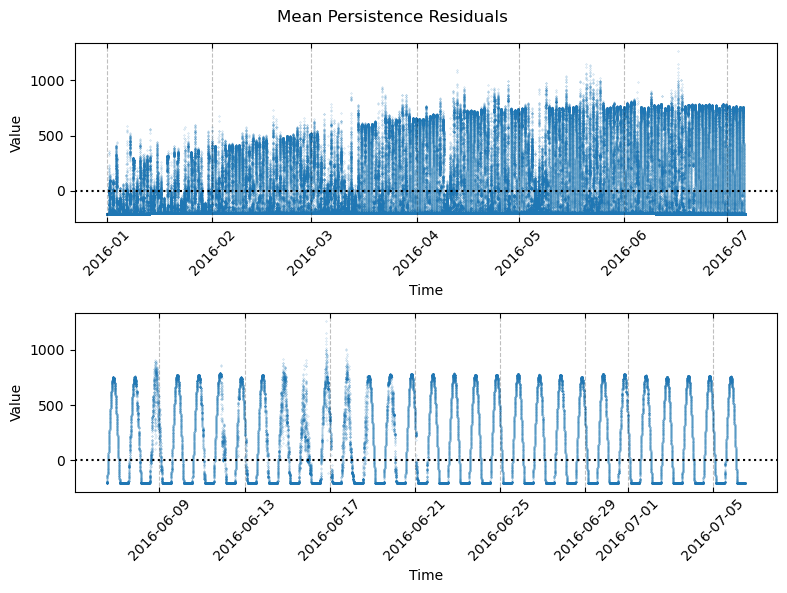

In [21]:
residual = (
    pd.Series(np.hstack(ground_truth) - np.hstack(forecasts))
)
residual.index = outsample_ghi_df.index[:len(np.hstack(ground_truth))]

fig, axs = plt.subplots(2, 1, figsize=(8, 6))

ax = visualize_time_series(
    ax=axs[0],
    time_series=residual,
    time_series_name="Residuals",
    s=0.05,
    alpha=0.5
)
ax=visualize_time_series(
    axs[1],
    time_series=residual[-(60 * 24 * 30):],
    time_series_name="Residuals",
    s=0.05,
    alpha=0.5
)


for ax in axs:
    ax.axhline(
        y=0,
        linestyle=":",
        c="k"
    )

plt.suptitle("Mean Persistence Residuals")
plt.tight_layout()
plt.show()

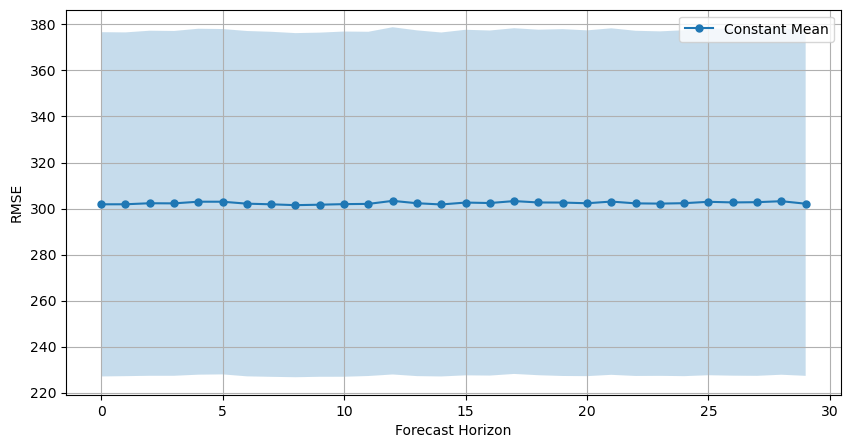

In [22]:
error_mean, error_sem = compute_rmse(
    y_true=np.array(ground_truth),
    y_forecast=np.array(forecasts),
    axis=0
)
MODELS_RESULTS["Constant Mean"] = {"error_mean": error_mean, "error_sem": error_sem}

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax = visualize_forecast_horizon_accuracy(
    ax=ax,
    model_name="Constant Mean",
    error_name="RMSE",
    error_mean=error_mean,
    error_sem=error_sem,
    marker="o",
    markersize=5
)
plt.legend()
plt.show()

### I - Mean Persistence Model

$$\hat{y}_{S+1} = \frac{1}{S} \sum_{s0}^S y_s$$

In [23]:
mean_persistence_model = (
    insample_ghi_df
    .groupby(["day_year", "hour"])
    ["ghi"]
    .mean()
    .reset_index()
    .rename({"ghi": "ghi_forecast"}, axis=1)
)


outsample_forecast = (
    outsample_ghi_df
    .merge(
        mean_persistence_model,
        how="left",
        on=["day_year", "hour"],
        
    )
    .interpolate(method="linear", limit_direction="both")
    [["ghi", "ghi_forecast"]]
)
outsample_forecast.index = outsample_ghi_df.index


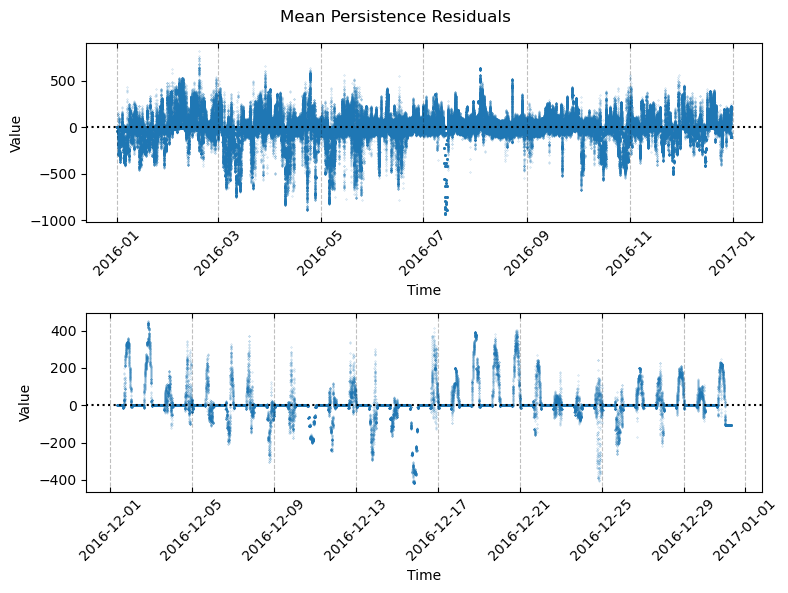

In [24]:
residual = outsample_forecast["ghi"] - outsample_forecast["ghi_forecast"]

fig, axs = plt.subplots(2, 1, figsize=(8, 6))

ax = visualize_time_series(
    ax=axs[0],
    time_series=residual,
    time_series_name="Residuals",
    s=0.05,
    alpha=0.5
)
ax=visualize_time_series(
    axs[1],
    time_series=residual[-(60 * 24 * 30):],
    time_series_name="Residuals",
    s=0.05,
    alpha=0.5
)


for ax in axs:
    ax.axhline(
        y=0,
        linestyle=":",
        c="k"
    )

plt.suptitle("Mean Persistence Residuals")
plt.tight_layout()
plt.show()

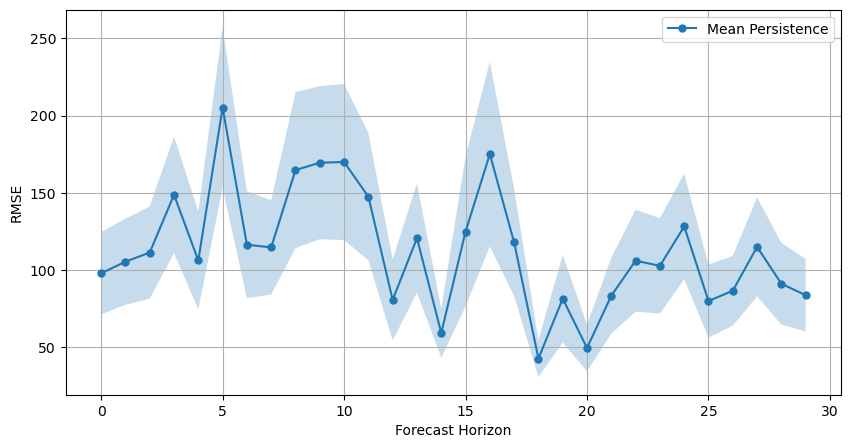

In [25]:
y_true = np.array(np.split(outsample_forecast["ghi"].values, 30)).T
y_forecast = np.array(np.split(outsample_forecast["ghi_forecast"].values, 30)).T

error_mean, error_sem = compute_rmse(
    y_true=y_true,
    y_forecast=y_forecast,
    axis=0
)
MODELS_RESULTS["Mean Persistence"] = {"error_mean": error_mean, "error_sem": error_sem}

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax = visualize_forecast_horizon_accuracy(
    ax=ax,
    model_name="Mean Persistence",
    error_name="RMSE",
    error_mean=error_mean,
    error_sem=error_sem,
    marker="o",
    markersize=5
)
plt.legend()
plt.show()

### II - Exponential Moving Average

$$\hat{y}_{T+1} = \frac{1}{T} \sum_{t0}^T y_t$$

In [26]:
from modules.models.baselines import ewm_forecast

ground_truth = []
forecasts = []
early_stop_counter = 0

for insample_indices, outsample_indices in tqdm(TIME_SERIES_SPLITTER.split(FULL_SERIES)):

    insample_series, outsample_series = FULL_SERIES[insample_indices], FULL_SERIES[outsample_indices]
    insample_forecast, outsample_forecast = ewm_forecast(
        time_series=insample_series,
        steps_ahead=30,
        alpha=0.5,
    )

    forecasts.append(outsample_forecast)
    ground_truth.append(outsample_series)
    early_stop_counter += 1

    if early_stop_counter > EARLY_STOP_LIMIT:
        break

0it [00:00, ?it/s]

5675it [02:14, 42.18it/s]


KeyboardInterrupt: 

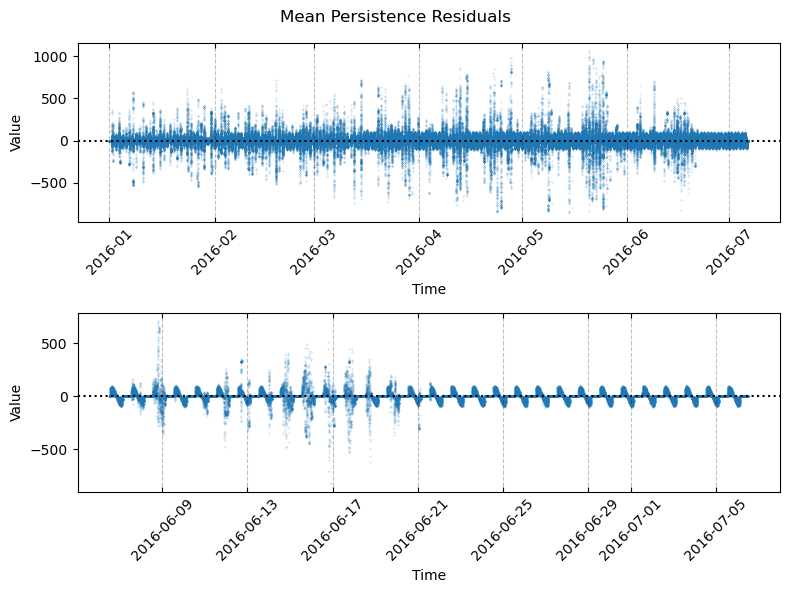

In [ ]:
residual = (
    pd.Series(np.hstack(ground_truth) - np.hstack(forecasts))
)
residual.index = outsample_ghi_df.index[:len(np.hstack(ground_truth))]

fig, axs = plt.subplots(2, 1, figsize=(8, 6))

ax = visualize_time_series(
    ax=axs[0],
    time_series=residual,
    time_series_name="Residuals",
    s=0.05,
    alpha=0.5
)
ax=visualize_time_series(
    axs[1],
    time_series=residual[-(60 * 24 * 30):],
    time_series_name="Residuals",
    s=0.05,
    alpha=0.5
)


for ax in axs:
    ax.axhline(
        y=0,
        linestyle=":",
        c="k"
    )

plt.suptitle("Mean Persistence Residuals")
plt.tight_layout()
plt.show()

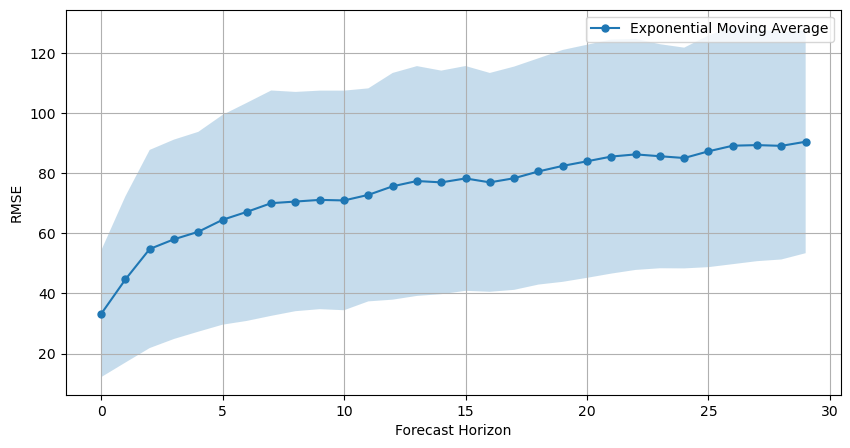

In [ ]:
error_mean, error_sem = compute_rmse(
    y_true=np.array(ground_truth),
    y_forecast=np.array(forecasts),
    axis=0
)
MODELS_RESULTS["Exponential Moving Average"] = {"error_mean": error_mean, "error_sem": error_sem}

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax = visualize_forecast_horizon_accuracy(
    ax=ax,
    model_name="Exponential Moving Average",
    error_name="RMSE",
    error_mean=error_mean,
    error_sem=error_sem,
    marker="o",
    markersize=5
)
plt.legend()
plt.show()

## IV - Gaussian Process Based Top-Down Forecast

$$
\hat{y}_{s_0 : S} \sim \mathcal{GP}(X)\\
\hat{y}_{S+1} = \boldsymbol{W}\hat{y}_{S}
$$

In [ ]:
daily_ghi_df = (
    insample_ghi_df
    .groupby(["day_year", "hour", "minute"])["ghi"]
    .mean()
    .reset_index()
    .groupby(["day_year"])["ghi"]
    .sum()
    .reset_index()
    .rename(
        {
            "ghi": "daily_ghi"
        },
    axis=1
    )
    .set_index(
        pd.date_range(
            start="2015-01-01", 
            end="2015-12-31",
            freq="d"
        )
    )
)

# We create a weighting scheme for going from hours to minutes
weighting_df = pd.merge(
    insample_ghi_df.groupby(["day_year", "hour", "minute"])["ghi"].mean().reset_index(),
    daily_ghi_df,
    how="left",
    on=["day_year"]
)

weighting_df["weight_day_to_minute"] = (weighting_df["ghi"] / weighting_df["daily_ghi"]).fillna(0)
weighting_df = weighting_df[["day_year", "hour", "minute", "ghi", "weight_day_to_minute"]]

weighting_df.index = insample_ghi_df[insample_ghi_df["year"] == 2015].index

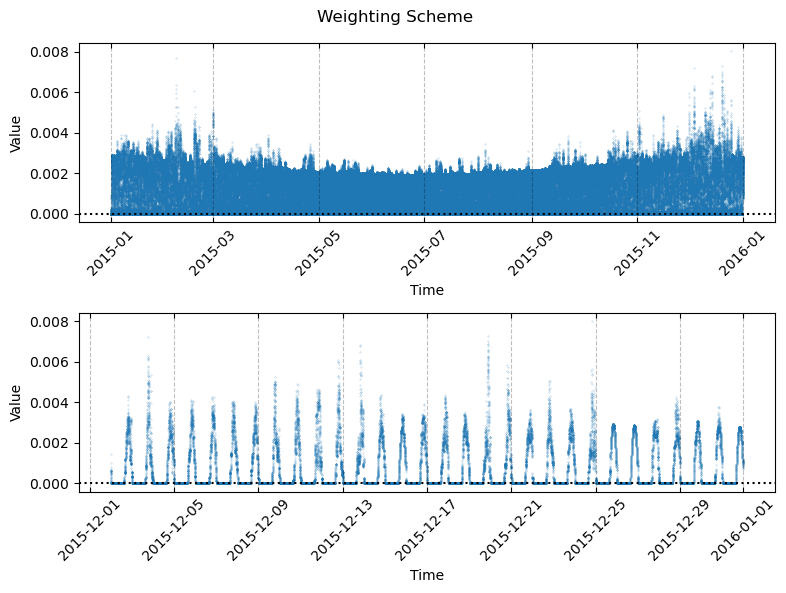

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(8, 6))

ax = visualize_time_series(
    ax=axs[0],
    time_series=weighting_df["weight_day_to_minute"],
    time_series_name="Weighting Day-Minute",
    s=0.05,
    alpha=0.5
)
ax=visualize_time_series(
    axs[1],
    time_series=weighting_df["weight_day_to_minute"][-(60 * 24 * 30):],
    time_series_name="Weighting Day-Minute",
    s=0.05,
    alpha=0.5
)


for ax in axs:
    ax.axhline(
        y=0,
        linestyle=":",
        c="k"
    )

plt.suptitle("Weighting Scheme")
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared, WhiteKernel

gaussian_process_scaler = StandardScaler()

yearly_seasonal_kernel = (
    ExpSineSquared(
        length_scale=1,
        periodicity=365.25, 
        periodicity_bounds="fixed"
    )
)
noise_kernel = (
    RBF(length_scale=30) + 
    WhiteKernel(
        noise_level=0.1**2, 
        noise_level_bounds=(1e-5, 1e5)
    )
)
gp_model = GaussianProcessRegressor(
    alpha=0.1,
    kernel=yearly_seasonal_kernel + noise_kernel,
    copy_X_train=False
)

y = (
    gaussian_process_scaler
    .fit_transform(daily_ghi_df["daily_ghi"].values.reshape(-1, 1))
    .flatten()
)
X = np.arange(len(y))


gp_model = gp_model.fit(X.reshape(-1, 1), y)
daily_ghi_df["estimated_daily_ghi"] = gaussian_process_scaler.inverse_transform(
    gp_model.predict(X.reshape(-1, 1)).reshape(-1, 1)
).flatten()

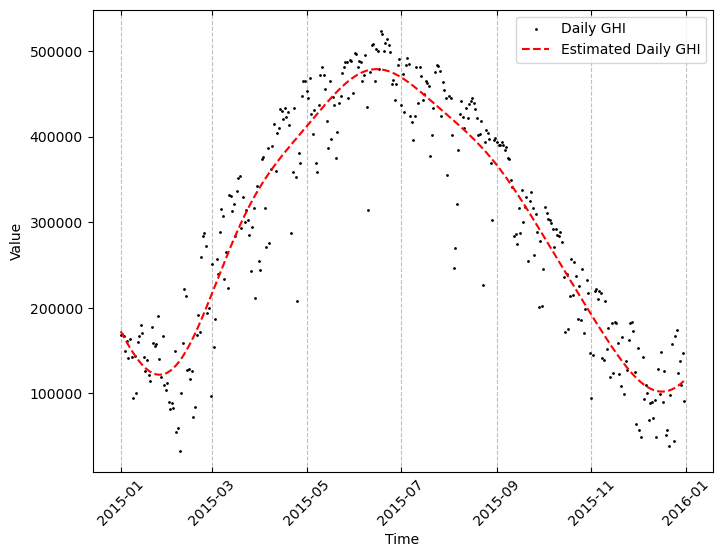

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax = visualize_time_series(
    ax=ax,
    time_series=daily_ghi_df["daily_ghi"],
    time_series_name="Daily GHI",
    s=1,
    c="k"
)
ax.plot(
    daily_ghi_df["estimated_daily_ghi"].index,
    daily_ghi_df["estimated_daily_ghi"].values,
    label="Estimated Daily GHI",
    c="r",
    linestyle="--"
)
plt.legend()
plt.show()

In [ ]:
estimated_minutely_ghi = (
    weighting_df[["day_year", "hour", "minute", "weight_day_to_minute"]]
    .merge(
        daily_ghi_df[["day_year", "estimated_daily_ghi"]],
        how="left",
        on="day_year"
    )
)
estimated_minutely_ghi["estimated_minutely_ghi"] = (
    estimated_minutely_ghi["estimated_daily_ghi"] * estimated_minutely_ghi["weight_day_to_minute"]
)
estimated_minutely_ghi = estimated_minutely_ghi[["day_year", "hour", "minute", "estimated_minutely_ghi"]]

outsample_forecast = (
    pd.merge(
        left=outsample_ghi_df[["day_year", "hour", "minute", "ghi"]],
        right=estimated_minutely_ghi,
        how="left",
        on=["day_year", "hour", "minute"]
    )
    .interpolate(method="linear", limit_direction="both")
)

outsample_forecast = outsample_forecast[["ghi", "estimated_minutely_ghi"]]
outsample_forecast.index = outsample_ghi_df.index

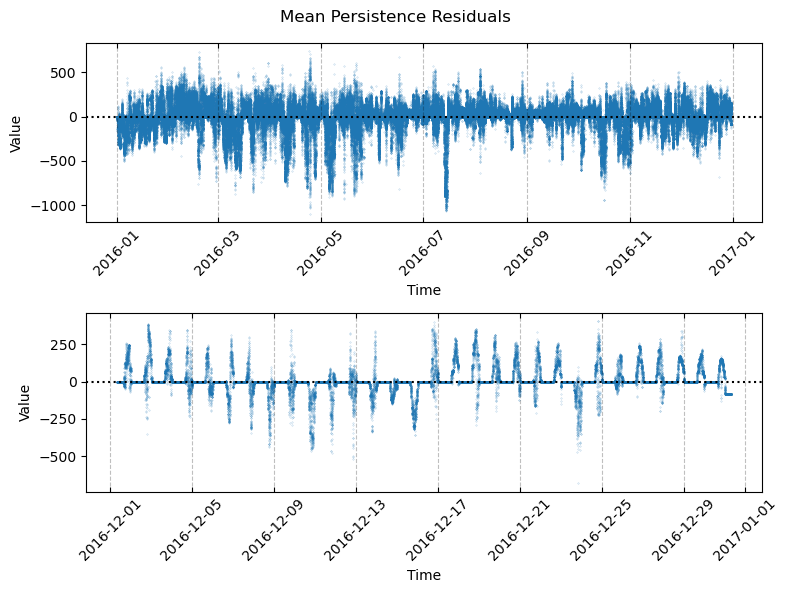

In [ ]:
residual = (
    outsample_forecast["ghi"] - outsample_forecast["estimated_minutely_ghi"]
)

fig, axs = plt.subplots(2, 1, figsize=(8, 6))

ax = visualize_time_series(
    ax=axs[0],
    time_series=residual,
    time_series_name="Residuals",
    s=0.05,
    alpha=0.5
)
ax=visualize_time_series(
    axs[1],
    time_series=residual[-(60 * 24 * 30):],
    time_series_name="Residuals",
    s=0.05,
    alpha=0.5
)


for ax in axs:
    ax.axhline(
        y=0,
        linestyle=":",
        c="k"
    )

plt.suptitle("Mean Persistence Residuals")
plt.tight_layout()
plt.show()

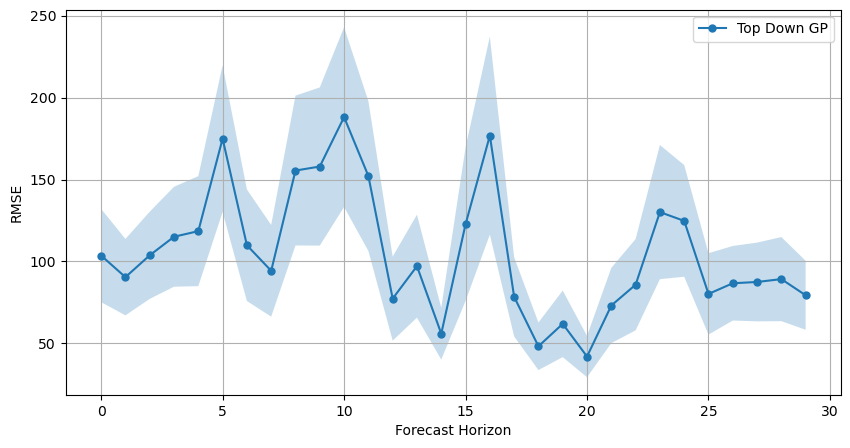

In [ ]:
y_true = np.array(np.split(outsample_forecast["ghi"].values, 30)).T
y_forecast = np.array(np.split(outsample_forecast["estimated_minutely_ghi"].values, 30)).T

error_mean, error_sem = compute_rmse(
    y_true=y_true,
    y_forecast=y_forecast,
    axis=0
)
MODELS_RESULTS["Top Down GP"] = {"error_mean": error_mean, "error_sem": error_sem}

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax = visualize_forecast_horizon_accuracy(
    ax=ax,
    model_name="Top Down GP",
    error_name="RMSE",
    error_mean=error_mean,
    error_sem=error_sem,
    marker="o",
    markersize=5
)
plt.legend()
plt.show()

## More Advanced Models

In [58]:
from torch.utils.data import  DataLoader
from modules.models.torch_backend.data_handlers import TimeseriesAutoregressiveDataset

AR_WINDOW = 30

insample_ghi_series = insample_ghi_df[insample_ghi_df.index <= "2015-01-02 08:00:00"]["ghi"].values
validation_ghi_series = insample_ghi_df[insample_ghi_df.index > "2015-01-02 08:00:00"]["ghi"].values

test_ghi_series = np.hstack([validation_ghi_series[-AR_WINDOW:],  outsample_ghi_df["ghi"].values])

insample_ar_dataset = TimeseriesAutoregressiveDataset(
    X=insample_ghi_series.astype("float32"),
    y=insample_ghi_series.astype("float32"),
    ar_window=AR_WINDOW,
    forecast_horizon=OUTSAMPLE_WINDOW_SIZE,
    gap=OUTSAMPLE_WINDOW_SIZE
)
validation_ar_dataset = TimeseriesAutoregressiveDataset(
    X=validation_ghi_series.astype("float32"),
    y=validation_ghi_series.astype("float32"),
    ar_window=AR_WINDOW,
    forecast_horizon=OUTSAMPLE_WINDOW_SIZE,
    gap=OUTSAMPLE_WINDOW_SIZE
)
validation_ar_dataset = TimeseriesAutoregressiveDataset(
    X=test_ghi_series.astype("float32"),
    y=test_ghi_series.astype("float32"),
    ar_window=AR_WINDOW,
    forecast_horizon=OUTSAMPLE_WINDOW_SIZE,
    gap=OUTSAMPLE_WINDOW_SIZE
)

train_loader = DataLoader(
    insample_ar_dataset,
    batch_size=2048,
    shuffle=True
)
validation_loader = DataLoader(
    insample_ar_dataset,
    batch_size=2048,
    shuffle=True
)
test_loader = DataLoader(
    insample_ar_dataset,
    batch_size=2048,
    shuffle=True
)

### I Regularized Auto Regressive Model

In [59]:
from torch.optim import Adam
from torch.nn import MSELoss, L1Loss

from modules.models.torch_backend.neural_networks.architectures import LinearModel, MLPModel
from modules.models.torch_backend.fitters import TorchModelFitter
from modules.models.torch_backend.callbacks import EarlyStopping


model = LinearModel(
    in_features=AR_WINDOW,
    out_features=OUTSAMPLE_WINDOW_SIZE,
    link_function="ReLU",
).to("cuda")
stopper = EarlyStopping(tolerance=100, min_delta=0.001)
fitter = TorchModelFitter()


model, optimizer, hisotry = fitter.fit(
    model=model,
    optimizer=Adam(model.parameters(), weight_decay=0.01),
    train_loader=train_loader,
    validation_loader=train_loader,
    stopper=stopper,
    epochs=10,
    loss_function=MSELoss()
)

  0%|          | 0/10 [00:00<?, ?it/s]

Loss 9596.2809 - Validation Loss 9601.2467: 100%|██████████| 10/10 [00:04<00:00,  2.13it/s] 

Loaded the latest best model state from epoch 10


In [60]:
forc = []
for i, j in test_loader:

    forc.append(model.forward(i.to("cuda")).to("cpu").detach().numpy().flatten())

plt.plot(np.hstack(forc)[-3000:])

### II Autoregressive Multilayer Perceptron

In [64]:
from modules.models.torch_backend.neural_networks.architectures import MLPModel

model = MLPModel(
    in_features=AR_WINDOW,
    out_features=OUTSAMPLE_WINDOW_SIZE,
    layers=(100, 100, 100),
    link_function="ReLU",
    activation_function="ReLU",
    dropout_rate=0.1,
).to("cuda")
stopper = EarlyStopping(tolerance=100, min_delta=0.001)
fitter = TorchModelFitter()


model, optimizer, hisotry = fitter.fit(
    model=model,
    optimizer=Adam(model.parameters(), weight_decay=0.01),
    train_loader=train_loader,
    validation_loader=train_loader,
    stopper=stopper,
    epochs=50,
    loss_function=MSELoss()
)

  0%|          | 0/50 [00:00<?, ?it/s]

Loss 4056.9803 - Validation Loss 4283.9112: 100%|██████████| 50/50 [00:18<00:00,  2.69it/s]  

Loaded the latest best model state from epoch 43


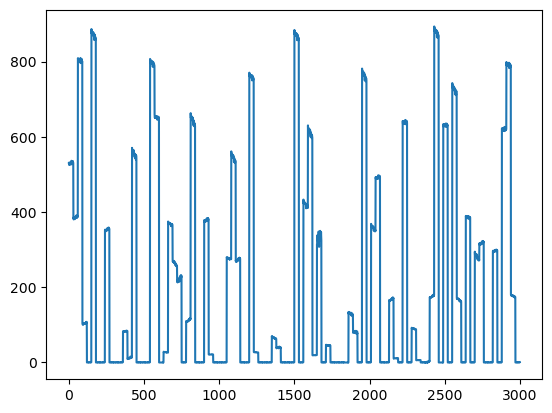

In [65]:
forc = []
for i, j in test_loader:

    forc.append(model.forward(i.to("cuda")).to("cpu").detach().numpy().flatten())

plt.plot(np.hstack(forc)[-3000:])

## Inferential Approach III - RNN + MLP

## IV - Generalized Addtive Linear Model (with MLP as as covariate model)

$$
\hat{y}_{t} = \alpha_{day}\phi_{day}(t) + \alpha_{year}\phi_{year}(t) + f(X_{t-2})
$$

Excluding the autograd functionality offered by JAX this model was developed from first principles using JAX numpy API

In [145]:
import numpy as np
from jax import random

from sklearn.preprocessing import MinMaxScaler

from modules.data_handling.features_generators import make_fourier_matrix


master_key = random.PRNGKey(666)

ghi_scaler = MinMaxScaler()
satellite_covariates_scaler = MinMaxScaler()

y_insample = insample_ghi_df["ghi"].values
y_outsample = outsample_ghi_df["ghi"].values

insample_satellite_covariates = insample_ghi_df[np.arange(1, 101)].values
insample_satellite_covariates = satellite_covariates_scaler.fit_transform(insample_satellite_covariates)

outsample_satellite_covariates = outsample_ghi_df[np.arange(1, 101)].values
outsample_satellite_covariates = satellite_covariates_scaler.fit_transform(outsample_satellite_covariates)

insample_time = np.arange(len(y_insample))
outsample_time = np.arange(insample_time.max(), insample_time.max() + len(y_outsample))

insample_fourier_matrix_year = make_fourier_matrix(
    time_series_indices=np.arange(len(y_insample)), 
    n_components=10, 
    period=525949.2
)
insample_fourier_matrix_day = make_fourier_matrix(
    time_series_indices=np.arange(len(y_insample)), 
    n_components=10, 
    period=1440
)
outsample_fourier_matrix_year = make_fourier_matrix(
    time_series_indices=outsample_time, 
    n_components=10, 
    period=525949.2
)
outsample_fourier_matrix_day = make_fourier_matrix(
    time_series_indices=outsample_time, 
    n_components=10, 
    period=1440
)

In [151]:
from modules.models.jax_backend.additive_models import custom_ghi_model
from modules.models.jax_backend.initializers import random_gaussian
from modules.models.jax_backend.activation_functions import relu
from modules.models.jax_backend.losses import mae

init_params, forward, backward, get_components = custom_ghi_model(
    seasonality_init_method=random_gaussian,
    covariates_init_method=random_gaussian,
    mlp_hidden_link_function=relu,
    mlp_init_method=random_gaussian,
    mlp_layers=(),
    link_function=relu,
    loss_function=mae,
    covariates_reg_strength=0.0001,
    seasonality_reg_strength=0.0001,
    prngkey=random.split(master_key)[1]
)

start_params = init_params(
    insample_fourier_matrix_year, 
    insample_fourier_matrix_day,
    covariates=insample_satellite_covariates
)

In [154]:
from modules.models.jax_backend.fitters import fit
from modules.models.jax_backend.optimizers import newton_rhapson
from modules.models.jax_backend.callbacks import EarlyStopping

params, history = fit(
    X=(
        insample_fourier_matrix_year,
        insample_fourier_matrix_day,
        insample_satellite_covariates
    ),
    y=y_insample, 
    backward=backward, 
    start_params=start_params, 
    optimizer=newton_rhapson(learning_rate=10),
    epochs=500, 
    stopper=EarlyStopping(tol=100), 
    verbose=1, 
    batch_size=None
)

Loss 33.56019973754883: 100%|██████████| 500/500 [04:54<00:00,  1.70it/s] 


/home/penthotal/Desktop/ghi_forecast/modules/diagnostics/metrics.py:26: RuntimeWarning: invalid value encountered in divide
  sape = (np.abs(y - yhat) / (np.abs(y) + np.abs(yhat))) * 100
/home/penthotal/mambaforge-pypy3/envs/ghi_forecast_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/penthotal/mambaforge-pypy3/envs/ghi_forecast_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/penthotal/Desktop/ghi_forecast/modules/diagnostics/visualizers.py:220: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return fig
/home/penthotal/mambaforge-pypy3/e

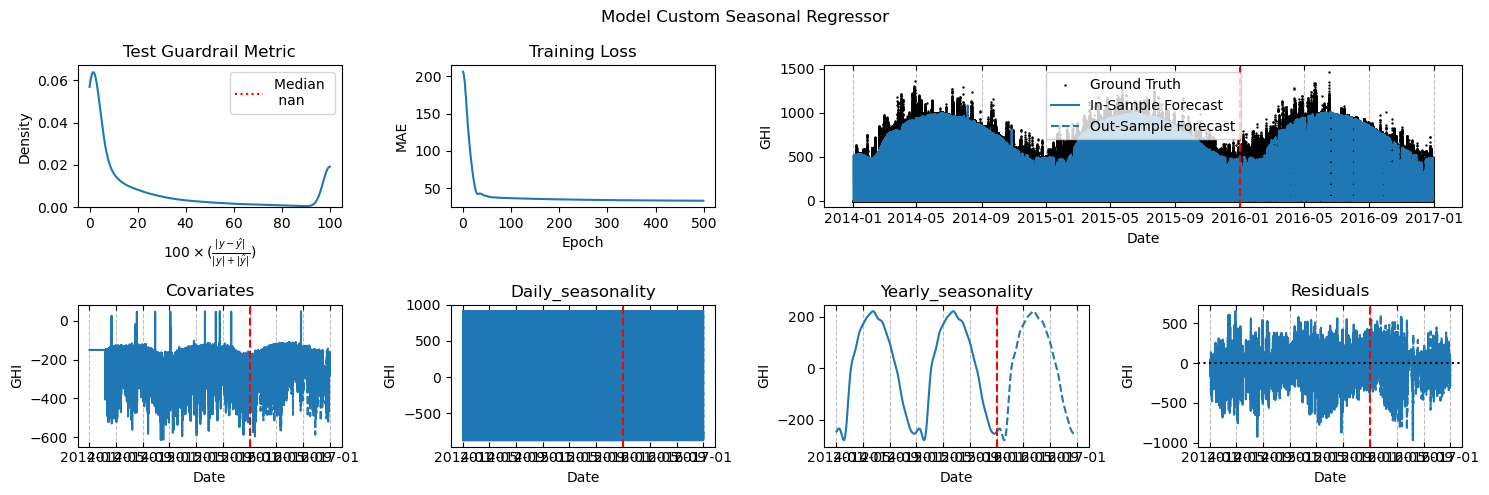

/home/penthotal/mambaforge-pypy3/envs/ghi_forecast_env/lib/python3.11/site-packages/IPython/core/events.py:93: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


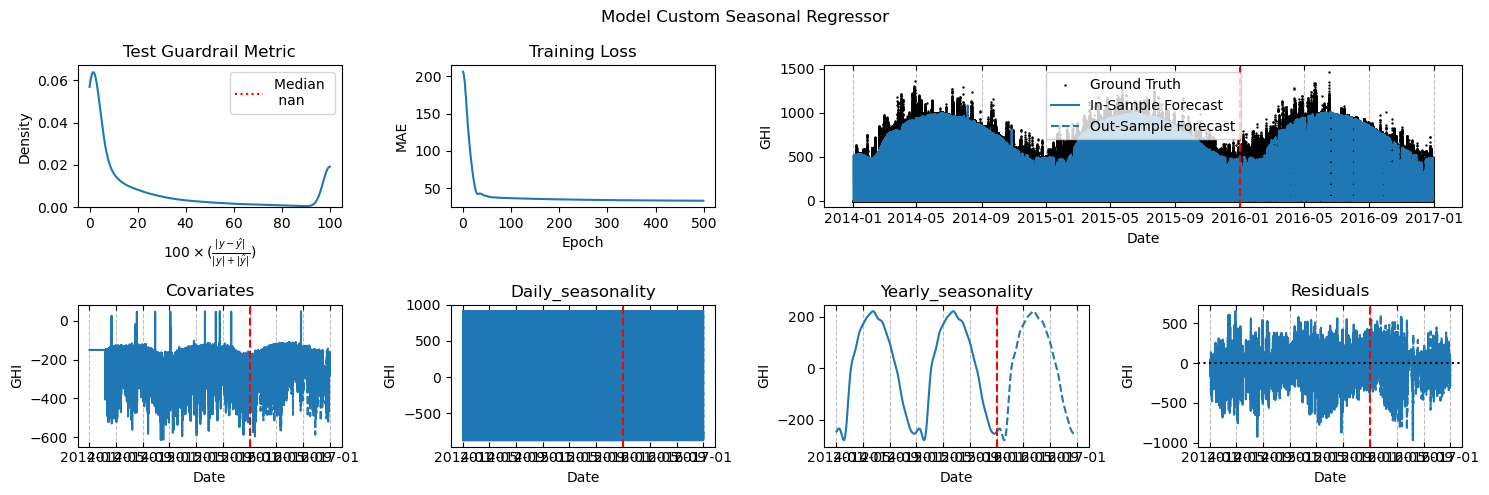

In [155]:
from modules.diagnostics.visualizers import visualize_time_series_components_performance

components_insample = get_components(
    (
        insample_fourier_matrix_year,
        insample_fourier_matrix_day,
        insample_satellite_covariates
    ),
    params,
    None
)
components_outsample= get_components(
    (
        outsample_fourier_matrix_year,
        outsample_fourier_matrix_day,
        outsample_satellite_covariates
    ),
    params,
    None
)

visualize_time_series_components_performance(
    time_series_train=insample_ghi_df["ghi"],
    time_series_test=outsample_ghi_df["ghi"],
    components_insample=components_insample,
    components_outsample=components_outsample,
    link_function=relu,
    target_name="GHI",
    model_name="Custom Seasonal Regressor",
    guardrail_metric=compute_symmetric_absolute_percentage_error,
    loss="MAE",
    history=history,
    figsize=(15, 5),
)